In [166]:

import numpy as np
import cv2
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import operator
import torchvision.transforms as transforms
import os
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
from itertools import chain
import mahotas as mt
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


In [159]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


# Loading the Dataset

In [77]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

print(len(folder_names))  # 102 = 101 categories + background


100


In [78]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

img_data = []
img_classes = []

num_categories = 10
num_imgs = 30
selected_categories = np.random.randint(0, 101, num_categories, dtype="I")

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))]

    for b, img_name in enumerate(image_names):
        img_classes.append(folder_names[cat])
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))

        if img is not None:
            img_data.append(img)


In [79]:
folder_path = r'C:\Users\Joe\Desktop\UNI\Yr3\Dissertation\Datasets\train_svm_DS'
full_path_files = []
root_list = []
dir_list = []
file_names = []
img_labels = []


for (root, dir, file) in os.walk(folder_path, topdown=True):
    root_list.append(root)
    dir_list.append(dir)
    file_names.append(file)
    
#remove root dir
root_list.pop(0)

for dir in range(len(root_list)):
    for f in file_names[dir+1]:
        img_labels.append(dir_list[0][dir])
        temp_name = os.path.join(root_list[dir], f)
        full_path_files.append(temp_name)
            

#flatten file names list
file_names = list(chain.from_iterable(file_names))


In [80]:
svm_train_db = []
for f in full_path_files:
    img = cv2.imread(f)
    img = cv2.resize(img, (100, 100))
    if img is not None:
        svm_train_db.append(img)


In [81]:
def load_cifar(dir):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])
    
    train = datasets.CIFAR10(root=dir,
                              train=True,
                              download=True,
                              transform=transform)
    
    test = datasets.CIFAR10(root=dir,
                             train=False,
                             download=True,
                             transform=transform)

    return train, test
    


In [82]:
path = r'C:\Users\Joe\Desktop\UNI\Yr3\Dissertation\Datasets\cifar'
trainset, testset = load_cifar(path)


Files already downloaded and verified
Files already downloaded and verified


In [83]:
batch_size = 64
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


# Global Functions

In [84]:
def normalise(distances, scale):
    scaler = MinMaxScaler((0, scale))
    keys = distances.keys()
    distances = np.array(list(distances.values()))
    distances = scaler.fit_transform(distances.reshape(-1, 1))
    distances = dict(zip(keys, distances))
    return distances

# Histogram features

In [85]:
def histogram_features(img):
    features = [] 
    pp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(pp_img)
    channel_names = ('h', 's', 'v')
    for (channel, channel_name) in zip(channels, channel_names):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist.flatten())
        return features

In [86]:
def hist_features_database(data_imgs):
    db_features = []
    for img in data_imgs:
        db_features.append(histogram_features(img))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [87]:
def calc_hist_distance(query_img, db_df):
    feature_vectors = db_df.values.tolist()
    distances = {}
    for a in range(len(feature_vectors)):
        query_features = histogram_features(query_img)
        dist = euclidean(query_features, feature_vectors[a])
        distances[a] = dist
    return normalise(distances, 20)

In [88]:
test_hist = hist_features_database(img_data)


# Gabor Features

In [89]:
def build_filters():
    filters = []
    kernal_size = 9 
    for theta in np.arange(0, np.pi, np.pi / 8):
        for deg in np.arange(0, 6*np.pi/4, np.pi / 4):
            kernal = cv2.getGaborKernel((kernal_size, kernal_size), 1.0, theta, deg, 0.5, 0, ktype= cv2.CV_32F)
            kernal /= 1.5 * kernal.sum()
            filters.append(kernal)
    return filters

In [90]:
def convolve_filters(img, filters):
    conv = np.zeros_like(img)
    for kernal in filters:
        filter_img = cv2.filter2D(img, cv2.CV_8UC3, kernal)
        np.maximum(conv, filter_img, conv)
    return conv

In [91]:
def gabor_features(img):
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filters = np.asarray(build_filters())
    
    for a in range(20):
        energy = 0
        conv = convolve_filters(img, filters[a])
        for b in range(img.shape[0]):
            for c in range(img.shape[1]):
                energy += conv[b][c] * conv[b][c]
        features.append(energy)
    for a in range(20):
        mean = 0
        conv = convolve_filters(img, filters[a])
        for b in range(img.shape[0]):
            for c in range(img.shape[1]):
                mean += abs(conv[a][b])
        features.append(mean)
    features = np.array(features)
    return features

In [92]:
def gabor_features_database(data_imgs):
    db_feat = []
    for img in data_imgs:
        db_feat.append(gabor_features(img))
    db_gabor_df = DataFrame(db_feat)
    return db_gabor_df

In [93]:
def calc_gabor_distance(query_img, db_df):
    distances = {}
    query_feat = gabor_features(query_img)
    feature_vector = db_df.values.tolist()
    
    for a in range(len(feature_vector)):
        distances[a] = euclidean(query_feat, feature_vector[a])
    distances = normalise(distances, 20)
    return distances

# Haralick Feature Testing

In [94]:
def haralick_features(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    texture = mt.features.haralick(img)
    features = texture.mean(axis=0)
    return features

In [95]:
def haralick_features_database(img_db):
    features = []
    for img in img_db:
        feat = haralick_features(img)
        features.append(feat)
    haralick_df = DataFrame(features)
    return haralick_df


In [96]:
def calc_haralick_distance(query_img, db_df):
    distances = {}
    query_feat = haralick_features(query_img)
    haralick_fv = db_df.values.tolist()
    for a in range(len(haralick_fv)):
        img_feats = haralick_fv[a]
        dist = euclidean(query_feat, img_feats)
        distances[a] = dist
    distances = normalise(distances, 20)
    return distances

# Distance Metric Calculation

In [97]:
def calc_distances_total(hist_dist, gabor_dist):
    total_dist = []
    hist_weight = 0.8
    gabor_weight = 0.2
    
    for a in hist_dist:
        hist_dist[a] *= hist_weight
        gabor_dist[a] *= gabor_weight
        total_dist.append(hist_dist[a] + gabor_dist[a])  
    return sorted(dict(zip(np.arange(0, len(img_data)), (np.array(total_dist)))).items(), key=operator.itemgetter(1))


In [98]:
query_img = img_data[0]

hist_dist = calc_hist_distance(query_img, hist_features_database(img_data))
gabor_dist = calc_gabor_distance(query_img, gabor_features_database(img_data))

final_dist = calc_distances_total(hist_dist, gabor_dist)

C:\Users\Joe\AppData\Local\Temp\ipykernel_16660\1077438191.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  energy += conv[b][c] * conv[b][c]


# Model 2 Testing

# HOG

In [99]:
import skimage
from skimage.feature import hog

In [100]:
def HOG_features(img, bin_n, norm):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1))
    b = np.linspace(0, np.max(fd), bin_n+1)
    histogram, _ = np.histogram(fd, bins=b)
    
    if norm:
        histogram = (histogram - histogram.mean()) / (histogram.std())
    
    return histogram

In [101]:
def HOG_hist(img, type_h, bin_n, slice_n, norm):
    
    if type_h == 'global':
        histogram = HOG_features(img, bin_n, norm)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, bin_n))
        slice_h = np.around(np.linspace(0, img.shape[0], slice_n +1)).astype(int)
        slice_w = np.around(np.linspace(0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = HOG_features(reigon, bin_n, norm)
            
    return histogram.flatten()


In [102]:
def HOG_db_feats(img_db, type_h, bin_n, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(HOG_hist(img, type_h, bin_n, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

# Colour Features 2.0

In [103]:
import itertools
import imageio.v3 as iio


In [104]:
def colour_features2(img):
    feats = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(img)
    channel_n = ('h', 's', 'v')
    for (channel, channel_n) in zip(channels, channel_n):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        feats.extend(hist)
    return feats
    

In [105]:
def colour_hist(img, type_h, bin_n, slice_n, norm):
    bins = np.linspace(0, 256, bin_n+1, endpoint=True)
    if type_h == 'global':
        histogram = colour_features2(img)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, 256 * img.shape[2]))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = colour_features2(reigon)
                
        if norm:
            histogram = (histogram - histogram.mean()) / (histogram.std())
        
    return np.array(histogram)


In [106]:
def colour_db_feats(img_db, type_h, bin_n, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(colour_hist(img, type_h, bin_n, slice_n, norm))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

# Gabor Feats 2.0

In [107]:
# gab imports
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import math

In [108]:
# create kernals at different orientations
def build_gabor_kernals(theta, freq, sigma):
    kern_l = []
    for t in range(theta):
        t = t / float(theta) * np.pi
        for f in freq:
                for s in sigma:
                    kern = gabor_kernel(f, theta = t, sigma_x=s, sigma_y=s)
                    kern_l.append(kern)
    return kern_l

In [109]:
def convolve_filters2(img, kern):
    
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    conv = np.sqrt(ndi.convolve(img, np.real(kern), mode='wrap')**2 +
        ndi.convolve(img, np.imag(kern), mode = 'wrap')**2)
    
    features = np.zeros(2, dtype = np.double)
    features[0] = conv.mean()
    features[1] = conv.var()
    return features

In [110]:
def gabor_features2(img, g_kernals, norm):
    g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    results = []
    
    for kern in g_kernals:
        results.append(convolve_filters2(g_img, kern))
    
    histogram = np.array(results)
    if norm:
        histogram = (histogram - histogram.mean()) / (histogram.std())
        
    return histogram.T.flatten()

In [111]:
def gabor(img, g_kernals, type_h, slice_n, norm):
    
    if type_h == 'global':
        histogram = gabor_features2(img, g_kernals, norm)
        
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, len(g_kernals)*2))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                reigon = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = gabor_features2(reigon, g_kernals, norm)
            
    return histogram.flatten()

In [112]:
def gabor_db_feats(img_db, g_kernals, type_h, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(gabor(img, g_kernals, type_h, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

# DAISY features 

In [113]:
# import====
from skimage.feature import daisy

In [114]:
def daisy_features(img, step, radius, ring_n, hist_n, oriant_n, norm = True):
    g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    R = (ring_n * hist_n + 1) * oriant_n
    desc = daisy(g_img, step = step, radius = radius, rings = ring_n,
                 histograms = hist_n, orientations = oriant_n)
    desc.reshape(-1, R)
    histogram = np.mean(desc, axis = 0)
    
    if norm:
        histogram = (histogram - histogram.mean()) / (histogram.std())
    return histogram


In [115]:
def daisy(img, type_h, slice_n, step, radius, ring_n, hist_n, oriant_n, norm):
    R = (ring_n * hist_n + 1) * oriant_n
    
    if type_h == 'global':
        histogram = daisy_features(img, step, radius, ring_n,
                                   hist_n, oriant_n, norm)
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, R))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                img_r = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = daisy_features(
                    img_r, step, radius, ring_n, hist_n, oriant_n, norm)
    
    if norm:
        histogram /= np.sum(histogram)
        
    return histogram


In [116]:
#test_daisy = daisy_features(img, 10, 30, 2, 6, 8)

In [117]:
#plt.imshow(daisy_img)


# Haralick 2 (similar to M1 implementation)

In [118]:
def haralick_features(img, norm):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    histogram = mt.features.haralick(img).mean(axis=0)
    if norm:
        histogram = np.array(histogram) / np.sum(histogram)
        
    return histogram


In [119]:
def haralick(img, type_h, slice_n, norm):
    if type_h == 'global':
        histogram = haralick_features(img, norm)
    
    elif type_h == 'reigon':
        histogram = np.zeros((slice_n, slice_n, 13))
        slice_h = np.around(np.linspace(
            0, img.shape[0], slice_n + 1)).astype(int)
        slice_w = np.around(np.linspace(
            0, img.shape[1], slice_n + 1)).astype(int)
        
        for h in range(len(slice_h)-1):
            for w in range(len(slice_w)-1):
                #create reigons for image
                img_r = img[slice_h[h]:slice_h[h+1], slice_w[w]: slice_w[w+1]]
                histogram[h][w] = haralick_features(img_r, norm)
        
        if norm:
            histogram = (histogram - histogram.mean()) / (histogram.std()) 

    return histogram.flatten()


In [120]:
def haralick_db_feats(img_db, type_h, slice_n, norm):
    db_features = []
    for img in img_db:
        db_features.append(haralick(img, type_h, slice_n, norm))
    db_df = DataFrame(db_features)
    return db_df

# M2 Feats

In [121]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


In [122]:
test_colour_db = hist_features_database(img_data)



In [123]:
test_colour_db = np.array(test_colour_db)


In [124]:
ds = img_data
type_h = 'reigon'
norm = False
slice_n = 2

scaler = MinMaxScaler()

#colour features
colour_f = colour_db_feats(ds, 'global', 12, 3, norm)
colour_f = scaler.fit_transform(colour_f)

#texture features
gabor_kernals = build_gabor_kernals(4, (0.1, 0.5, 0.8), (1, 3))
gab_f = gabor_db_feats(ds, gabor_kernals, type_h, slice_n, norm)
gab_f = scaler.fit_transform(gab_f)


hara_f = haralick_db_feats(ds, type_h, slice_n, norm)
hara_f = scaler.fit_transform(hara_f)


#shape features
hog_b = 10 # number of bins for each img
HOG_f = HOG_db_feats(ds, type_h, hog_b, slice_n, norm)
HOG_f = scaler.fit_transform(HOG_f)

In [125]:
print("Colour F Shape: {}".format(colour_f.shape))
print("Gab F Shape: {}".format(gab_f.shape))
print("Hara F Shape: {}".format(hara_f.shape))
print("HOG F Shape: {}".format(HOG_f.shape))

Colour F Shape: (608, 768)
Gab F Shape: (608, 192)
Hara F Shape: (608, 52)
HOG F Shape: (608, 40)


In [126]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


# Feature Fusion

In [145]:
# Colour + HOG
hog_clr = np.concatenate((colour_f, HOG_f), axis=1)
hog_clr_train, hog_clr_test, _, __ = train_test_split(
    hog_clr, img_classes, test_size=0.3, random_state=42)


In [146]:
# Colour + Gab
gab_clr = np.concatenate((colour_f, gab_f), axis=1)
gab_clr_train, gab_clr_test, _, __ = train_test_split(
    gab_clr, img_classes, test_size=0.3, random_state=42)


In [147]:
# Gab + HOG
gab_hog = np.concatenate((gab_f, HOG_f), axis=1)
gab_hog_train, gab_hog_test, _, __ = train_test_split(
    gab_hog, img_classes, test_size=0.3, random_state=42)


In [148]:
# Colour + Gab + Har + HOG
feat_vector = np.concatenate((colour_f, gab_f, hara_f, HOG_f), axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(
    feat_vector, img_classes, test_size=0.3, random_state=42)


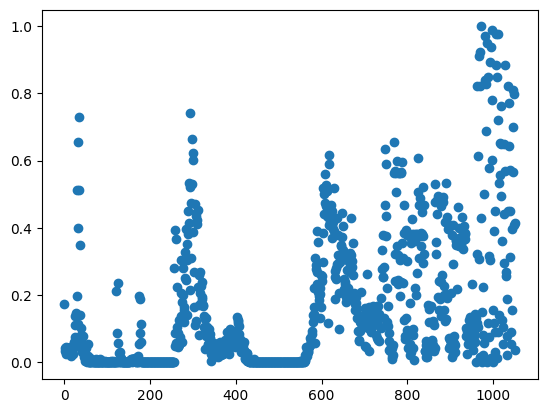

In [156]:
plt.scatter(np.arange(0, X_train.shape[1]), X_train[21])


# Image Classification Testing

In [162]:
target_names = set(img_classes)

In [167]:
# evaluate model
def evaluate_model(model, train_x, train_y):
  # K fold resampling
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, train_x, train_y,
	                         scoring='accuracy', cv=cv, n_jobs=-1)
	return scores


In [168]:
def get_models():
    models = dict()
    models['Naive Bayes'] = GaussianNB()
    models['Logistic Regression'] = LogisticRegression()
    models['K-Nearest Neighbors'] = KNeighborsClassifier()
    models['Linear Support Vector Machine'] = LinearSVC()
    return models

models = get_models()
results, modelName = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X_train, Y_train)
  results.append(scores)
  modelName.append(name)


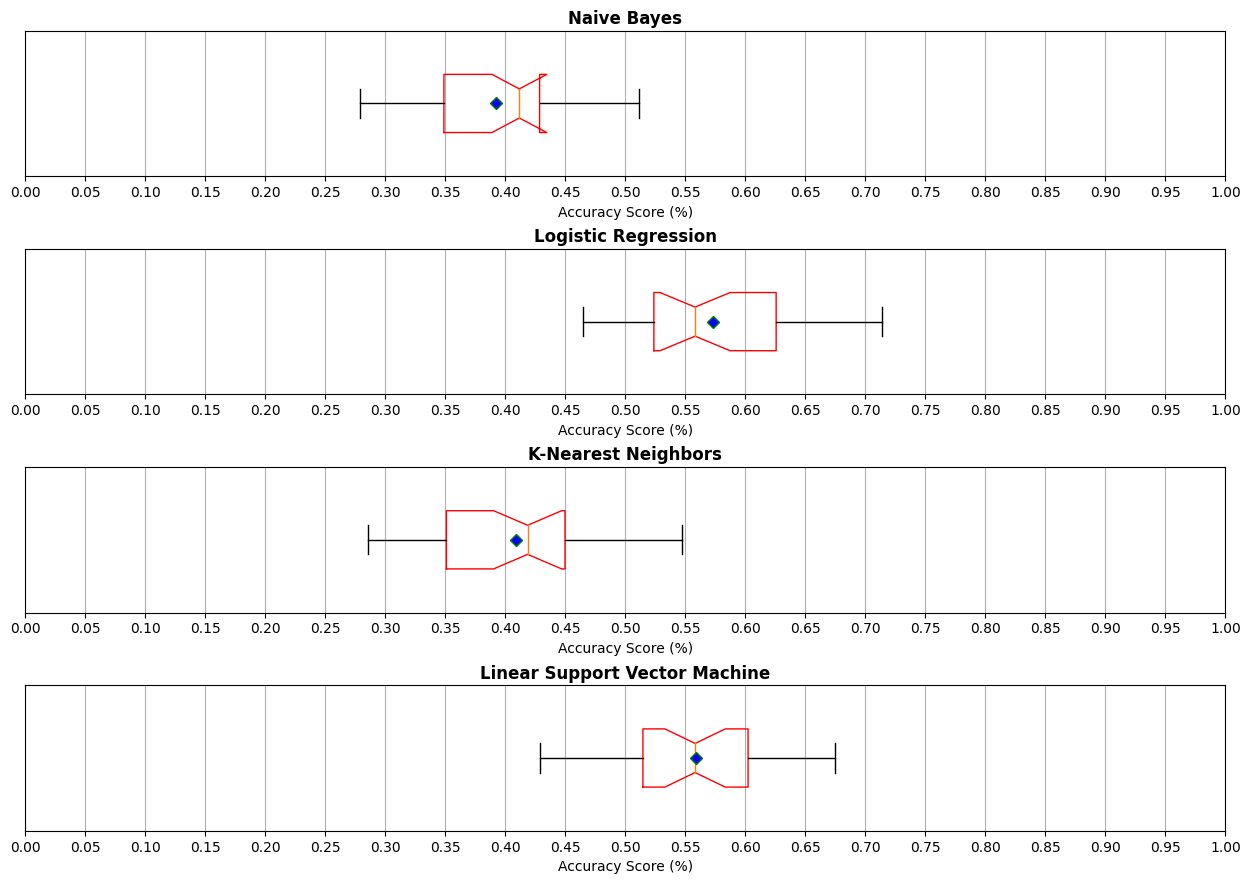

In [173]:
# create boxplots for comaprision
#set x ticks
xticks = np.arange(0.0, 1.05, 0.05, dtype=float)

#create markers
red_circle = dict(markerfacecolor='red', marker='.', markersize=7)
mean_shape = dict(markerfacecolor='blue', marker='D', markeredgecolor='green')

#create subplots
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.50, wspace=0.01, left=0, right=1, bottom=0, top=1)

#plot boxplot for each model
for a in range(len(ax)):
    ax[a].boxplot(results[a], boxprops=dict(color='red'), vert=False, flierprops=red_circle,
                  showmeans=True, meanprops=mean_shape, notch=True, widths=0.4)
    ax[a].set_xticks(xticks)
    ax[a].xaxis.grid(True)
    ax[a].get_yaxis().set_visible(False)
    ax[a].set_title(f"{modelName[a]}", fontsize=12,
                    y=0.99, fontweight='bold')
    ax[a].set_xlabel('Accuracy Score (%)')


In [160]:
clf = GaussianNB()

clf.fit(hog_clr_train, Y_train)

Y_train_pred = clf.predict(hog_clr_train)
Y_test_pred = clf.predict(hog_clr_test)

In [150]:
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=3000)
clf.fit(X_train, Y_train)

LinearSVC(max_iter=3000, random_state=0, tol=1e-05)

# Test

In [151]:
from sklearn.metrics import plot_confusion_matrix

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


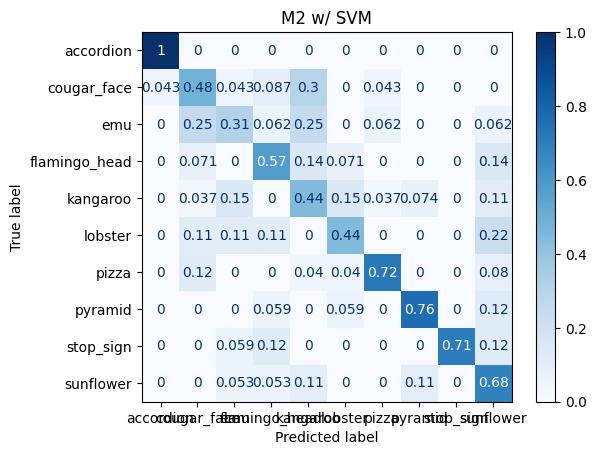

In [152]:
# Generate confusion matrix
matrix = plot_confusion_matrix(clf, X_test, Y_test,
                               cmap=plt.cm.Blues,
                               normalize='true')
plt.title('M2 w/ SVM')
plt.show(matrix)
plt.show()
